In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [84]:
class KalmanFilter:
    def __init__(self, sigma_x, sigma_q):
        sigma_v = 10.0
        self.sigma_x = sigma_x
        self.P = np.array([[sigma_x*sigma_x, sigma_x*sigma_x, sigma_x*sigma_v, sigma_x*sigma_v], 
                           [sigma_x*sigma_x, sigma_x*sigma_x, sigma_x*sigma_v, sigma_x*sigma_v],
                           [sigma_v*sigma_x, sigma_v*sigma_x, sigma_v*sigma_v, sigma_v*sigma_v],
                           [sigma_v*sigma_x, sigma_v*sigma_x, sigma_v*sigma_v, sigma_v*sigma_v]])
        
        self.R = np.identity(2) * (sigma_x*sigma_x)
        self.is_init = False
        
    def predict(self, dt):
        A = np.array([[1.0, 0.0, dt, 0.0],
                      [0.0, 1.0, 0.0, dt],
                      [0.0, 0.0, 1.0, 0.0],
                      [0.0, 0.0, 0.0, 1.0]])
        self.x = A.dot(self.x)
        A_t = np.transpose(A)
        Q = np.array([[pow(dt, 4)/4, 0.0, pow(dt, 3)/2, 0.0],
                      [0.0, pow(dt, 4)/4, 0.0, pow(dt, 3)/2],
                      [pow(dt, 3)/2, 0.0, pow(dt, 2), 0.0],
                      [0.0, pow(dt, 3)/2, 0.0, pow(dt, 2)]]) * self.sigma_x
        self.P = A.dot(self.P).dot(A_t) + Q
    
    def update(self, measurement):
        H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
        
        PHt = self.P.dot(H.T)
        print ('PHt =')
        print (PHt)
        S = H.dot(PHt) + self.R
        print ('S = ')
        print (S)
        
        S_i = np.linalg.inv(S)
        print ('S_i = ')
        print (S_i)
        
        K = PHt.dot(S_i)
        print ('K = ')
        print (K)
        
        z = np.matrix(measurement).T
        print ('z = ')
        print (z)
        U = z - H.dot(self.x)
        print ('U =')
        print (U)
        self.x = self.x + K.dot(z - H.dot(self.x))
        I = np.identity(4)
        self.P = (I - K.dot(H)).dot(self.P)
        
    def process(self, measurement, dt):
        print ('-'*50)
        print ('measurement = ', measurement)
        if not self.is_init:
            self.x = np.array([[measurement[0]],[measurement[1]], [0.0], [0.0]])
            self.is_init = True
        else:
            print ('x = ')
            print (self.x)
            self.predict(dt)
            print ('x_predicted = ')
            print ( self.x)
            self.update(measurement)
        print ('x_ouput = ')
        print (self.x)
        print ('P =')
        print (self.P)

    def state(self):
        return self.x

    def covar(self):
        return self.P

In [91]:
sigma = .5
sigma_q = 0.3
v_x = 10.0
v_y = 5.0
dt = 1.0

x_actual = 10.0
y_actual = 0.0

kf = KalmanFilter(sigma, sigma_q)
no_iter = 100

measured_x = []
measured_y = []
actual_x = []
actual_y = []
position_x = []
position_y = []
vs_x = []
vs_y = []
covars_x = []
covars_y = []
t = range(no_iter)


for i in t:
    x_measured = random.gauss(x_actual, sigma)
    y_measured = random.gauss(y_actual, sigma)
    kf.process([x_measured, y_measured], dt)

    measured_x.append(x_measured - x_actual)
    measured_y.append(y_measured - y_actual)
    actual_x.append(x_actual)
    actual_y.append(y_actual)
    position_x.append(kf.state()[0][0] - x_actual)
    position_y.append(kf.state()[1][0] - y_actual)
    vs_x.append(kf.state()[2][0] - v_x)
    vs_y.append(kf.state()[3][0] - v_y)
    
    covars_x.append(kf.covar()[0][0])
    covars_y.append(kf.covar()[1][1])

    x_actual += v_x*dt
    y_actual += v_y*dt

--------------------------------------------------
measurement =  [9.726499028737937, 0.3833755541612407]
x_ouput = 
[[ 9.72649903]
 [ 0.38337555]
 [ 0.        ]
 [ 0.        ]]
P =
[[   0.25    0.25    5.      5.  ]
 [   0.25    0.25    5.      5.  ]
 [   5.      5.    100.    100.  ]
 [   5.      5.    100.    100.  ]]
--------------------------------------------------
measurement =  [20.736644700028318, 4.822741539796512]
x = 
[[ 9.72649903]
 [ 0.38337555]
 [ 0.        ]
 [ 0.        ]]
x_predicted = 
[[ 9.72649903]
 [ 0.38337555]
 [ 0.        ]
 [ 0.        ]]
PHt =
[[ 110.375  110.25 ]
 [ 110.25   110.375]
 [ 105.25   105.   ]
 [ 105.     105.25 ]]
S = 
[[ 110.625  110.25 ]
 [ 110.25   110.625]]
S_i = 
[[ 1.33559706 -1.33106961]
 [-1.33106961  1.33559706]]
K = 
[[ 0.66610074  0.3327674 ]
 [ 0.3327674   0.66610074]
 [ 0.80928127  0.1426146 ]
 [ 0.1426146   0.80928127]]
z = 
[[ 20.7366447 ]
 [  4.82274154]]
U =
[[ 11.01014567]
 [  4.43936599]]
x_ouput = 
[[ 18.53764145]
 [  7.004258

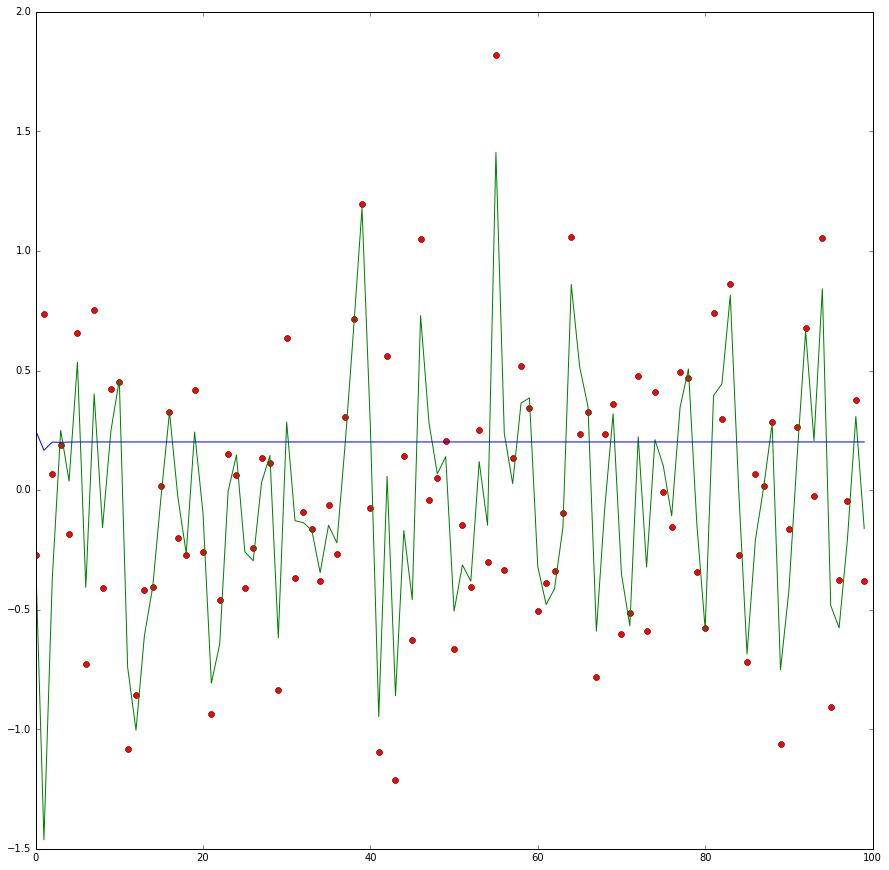

In [92]:
plt.figure(figsize=(15, 15))
plt.plot(t, measured_x, 'ro', t, position_x, 'g', t, covars_x, 'b')
plt.show()

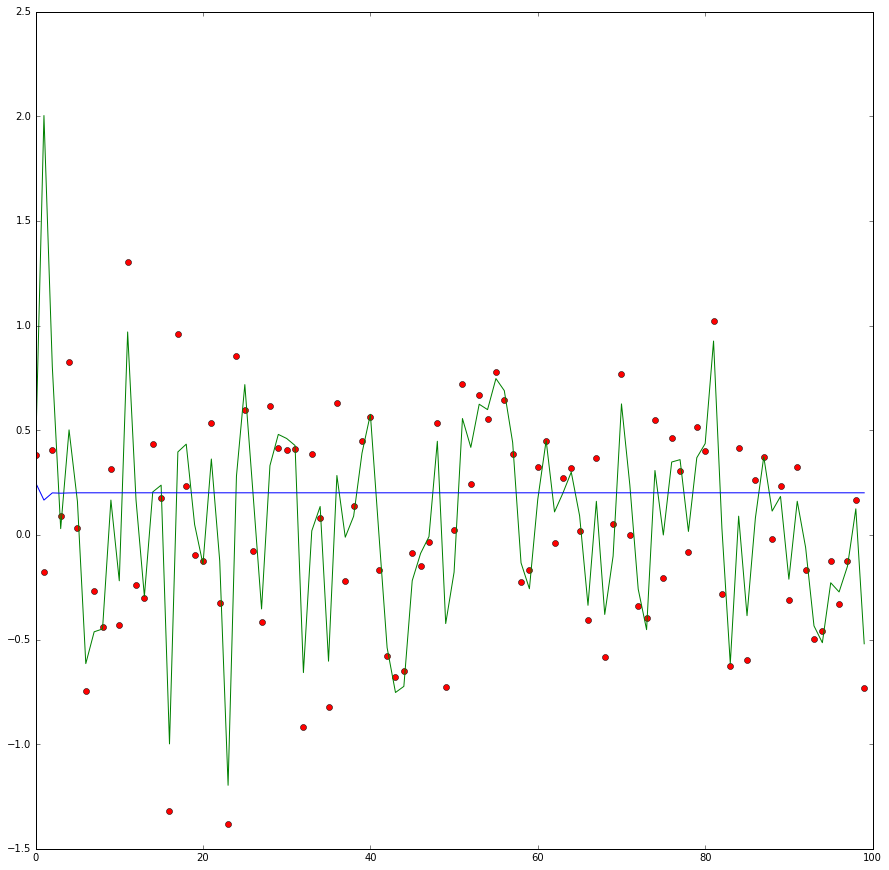

In [93]:
plt.figure(figsize=(15, 15))
plt.plot(t, measured_y, 'ro', t, position_y, 'g', t, covars_y, 'b')
plt.show()